#### Paper one
---
Modal disparities in spatiotemporal accessibility to non-work activities on the commute home from work in Warsaw, Poland
===

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

### parameters

In [2]:
Bs= [60, 75, 90, 105, 120] 
t_ks = [10, 20, 30, 40, 50, 60]

In [ ]:
B = 90
t_k = 20

### prepare

In [3]:
od_PuT = pd.read_csv('data//MTX_99321.csv', index_col = 'Unnamed: 0')
od_PuT.columns = [int(c) for c in od_PuT.columns]
od_PrT = pd.read_csv('data//MTX_99421.csv', index_col = 'Unnamed: 0')
od_PrT.columns = [int(c) for c in od_PrT.columns]
od_PrT = od_PrT.stack().reset_index()
od_PrT.columns=['Z_Rejon',"Do_Rejon", 'TripsPrT']
od_PrT.TripsPrT = od_PrT.TripsPrT.astype('int32')
od_PuT = od_PuT.stack().reset_index()
od_PuT.columns=['Z_Rejon',"Do_Rejon", 'TripsPuT']
od_PuT.TripsPuT = od_PuT.TripsPuT.astype('int32')
od_PrT = od_PrT[od_PrT.TripsPrT.astype(int)>0]
od_PuT = od_PuT[od_PuT.TripsPuT.astype(int)>0]
od = pd.merge(od_PrT, od_PuT, on = ['Z_Rejon', "Do_Rejon"])

In [4]:
od.Z_Rejon = od.Z_Rejon.astype('int32')
od.Do_Rejon=od.Do_Rejon.astype('int32')
od.TripsPrT=od.TripsPrT.astype('float32')
od.TripsPuT=od.TripsPuT.astype('float32')

In [5]:
usecols = ['Z_Rejon','POI','Do_Rejon','Czas_PrT','Czas_PuT']
dtype={'Unnamed: 0':'int32','Z_Rejon': 'int16',
       'Czas_PrT': 'float32',
 'Czas_PuT': 'float32',
 'Do_Rejon': 'int16',
 'POI': 'int16'}
trips = pd.read_csv('data//From_Via_To.csv', dtype = dtype)
del trips['Unnamed: 0']

In [8]:
trips = trips[trips.Czas_PrT<600]
trips = trips[trips.Czas_PuT<600]

In [9]:
trips.shape

(112143048, 5)

In [10]:
trips = pd.merge(trips,od, on = ['Z_Rejon',"Do_Rejon"])

In [12]:
trips = trips[['Z_Rejon','POI','Do_Rejon','Czas_PrT','Czas_PuT']]

In [13]:
trips.columns = ['j','k','i','t_jki_Car','t_jki_PT']

In [14]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347447 entries, 0 to 1347446
Data columns (total 5 columns):
j            1347447 non-null int16
k            1347447 non-null int16
i            1347447 non-null int16
t_jki_Car    1347447 non-null float32
t_jki_PT     1347447 non-null float32
dtypes: float32(2), int16(3)
memory usage: 28.3 MB


### data

In [15]:
trips.head()

,j,k,i,t_jki_Car,t_jki_PT
0,1,30,5,19.30,5.49
1,1,174,5,35.63,10.98
2,1,178,5,35.74,10.30
3,1,74,5,40.77,11.84
4,1,154,5,40.84,11.90


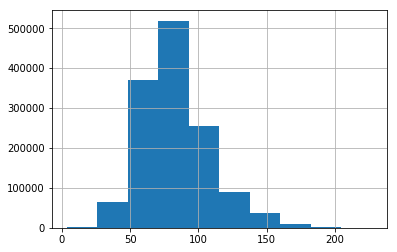

In [17]:
trips[trips['t_jki_Car']<400]['t_jki_Car'].hist()

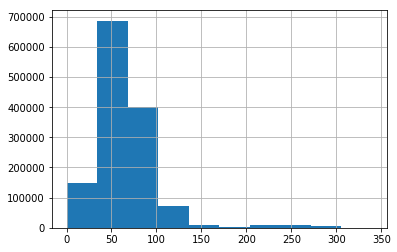

In [18]:
trips[trips['t_jki_PT']<400]['t_jki_PT'].hist()

# 3.2.
The time-geographic accessibility of a person leaving work in zone j stopping at non-work location k on the way home in zone i is calculated as:

 $A_{jki} = max(0,B-(t_{jk}+t_{k}+t_{ki}))$  (1)

$B$ = travel time budget in minutes

$t_jk$  = travel time in minutes from work location j to non-work location k

$t_k$  = minimum time required to participate in activity at location k

$t_ki$  = travel time in minutes from non-work location k to home location i

$A_jki$  = number of minutes available for person working in location j and living in location i to consume goods or services at location k given available travel budget B and minimum activity duration $t_k$ .


In [16]:
trips['A_jki_Car'] = B - trips.t_jki_Car - t_k
trips.A_jki_Car[trips.A_jki_Car < 0] = 0
trips.A_jki_Car[trips.A_jki_Car > 0] = trips.A_jki_Car + t_k
trips['A_jki_PT'] = B - trips.t_jki_PT - t_k
trips.A_jki_PT[trips.A_jki_PT < 0] = 0
trips.A_jki_PT[trips.A_jki_PT > 0] = trips.A_jki_PT + t_k

In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_
aggs = ['mean','min','max','std','median', percentile(25), percentile(75)]

The commute-based work-home accessibility, $A_{ji}^C$, is calculated by:

$A_{ji}^C = \frac{\sum_{k \in K} A_{jki}}{n} $ (2)

In [20]:
A_ji_C_Car = trips[trips.A_jki_Car>0].groupby(by=['i','j'])['A_jki_Car'].agg(aggs)
A_ji_C_Car.columns = ['A_ji_C_Car' + "_"+ str(col)  for col in A_ji_C_Car.columns]
A_ji_C_Car.to_csv('data//A_ji_C_Car.csv')
A_ji_C_Car.head()

A_ji_C_Car_mean  A_ji_C_Car_min  A_ji_C_Car_max  A_ji_C_Car_std  \
i j                                                                    
1 3            36.84           20.15           75.60            9.71   
  4            35.80           20.48           75.60            9.08   
  5            36.87           20.29           74.60            9.43   
  6            38.69           20.17           71.22            9.16   
  7            37.51           21.01           73.02            9.47   

     A_ji_C_Car_median  A_ji_C_Car_p_25  A_ji_C_Car_p_75  
i j                                                       
1 3              37.85            29.74            39.26  
  4              33.31            31.42            39.13  
  5              37.72            30.21            39.45  
  6              39.85            32.41            41.26  
  7              38.56            31.60            40.94

In [21]:
A_ji_C_PT = trips[trips.A_jki_PT>0].groupby(by=['i','j'])['A_jki_PT'].agg(aggs)
A_ji_C_PT.columns = ['A_ji_C_PT_' + str(col)  for col in A_ji_C_PT.columns]
A_ji_C_PT.to_csv('data//A_ji_C_PT.csv')
A_ji_C_PT.head()

A_ji_C_PT_mean  A_ji_C_PT_min  A_ji_C_PT_max  A_ji_C_PT_std  \
i j                                                                
1 3           52.72          20.11          84.81          14.42   
  4           52.34          20.62          83.21          14.43   
  5           53.64          20.57          84.10          14.60   
  6           53.76          20.99          83.22          14.70   
  7           54.03          21.45          82.00          14.42   

     A_ji_C_PT_median  A_ji_C_PT_p_25  A_ji_C_PT_p_75  
i j                                                    
1 3             56.32           42.96           61.71  
  4             55.95           42.60           61.34  
  5             57.92           44.52           62.68  
  6             58.34           44.95           62.80  
  7             58.80           45.40           63.44

Similarly, the commute-based home accessibility, $A_i^C$, is calculated by:

$A_{i}^C = \frac{\sum_{k \in K} A_{jki}}{n} $ (3)

In [22]:
A_i_C_Car = trips[trips.A_jki_Car>0].groupby(by=['i'])['A_jki_Car'].agg(aggs)
A_i_C_Car.columns = ['A_i_C_Car_' + str(col)  for col in A_i_C_Car.columns]
A_i_C_Car.to_csv('data//A_i_C_Car.csv')
A_i_C_Car.head()

,A_i_C_Car_mean,A_i_C_Car_min,A_i_C_Car_max,A_i_C_Car_std,A_i_C_Car_median,A_i_C_Car_p_25,A_i_C_Car_p_75
i,,,,,,,
1,36.35,20.00,75.60,9.17,36.16,29.20,43.10
3,39.13,20.04,63.84,8.56,39.81,33.13,45.18
5,40.07,20.03,70.70,9.34,39.94,33.38,47.44
6,40.50,20.05,71.60,9.41,41.32,34.16,47.75
7,41.99,20.05,71.82,9.78,42.73,35.49,49.62


In [23]:
A_i_C_PT = trips[trips.A_jki_PT>0].groupby(by=['i'])['A_jki_PT'].agg(aggs)
A_i_C_PT.columns = ['A_i_C_PT_' + str(col)  for col in A_i_C_PT.columns]
A_i_C_PT.to_csv('data//A_i_C_PT.csv')
A_i_C_PT.head()

,A_i_C_PT_mean,A_i_C_PT_min,A_i_C_PT_max,A_i_C_PT_std,A_i_C_PT_median,A_i_C_PT_p_25,A_i_C_PT_p_75
i,,,,,,,
1,49.94,20.01,84.84,13.43,51.50,40.73,60.13
3,55.24,20.22,81.38,14.31,60.01,45.45,66.33
5,53.79,20.24,84.51,14.93,57.43,41.97,66.73
6,54.90,20.04,84.52,14.82,59.11,42.43,67.30
7,56.39,20.05,83.42,15.27,60.88,45.86,68.74


# 3.3 Home-based accessibility

For comparisons with previous modal accessibility disparity studies described earlier, a time-geographic accessibility metric is developed to measure the time available to consume goods or services at location k based on a trip from and to the home location i. The number of minutes available on a home-based trip, A_iki^ , is calculated by:

$A_{iki} = max(0,B-(t_{ik}+t_{k}+t_{ki}))$ (4)

In [24]:
hb = trips[trips.i == trips.j]

$A_{i}^H = \frac{\sum_{k \in K} A_{iki}}{n} $ (5)

In [25]:
A_i_H_Car = hb[hb.A_jki_Car>0].groupby(by=['i'])['A_jki_Car'].agg(aggs)
A_i_H_Car.columns = ['A_i_H_Car_' + str(col)  for col in A_i_H_Car.columns]
A_i_H_Car.to_csv('data//A_i_H_Car.csv')
A_i_H_Car.head()

,A_i_H_Car_mean,A_i_H_Car_min,A_i_H_Car_max,A_i_H_Car_std,A_i_H_Car_median,A_i_H_Car_p_25,A_i_H_Car_p_75
i,,,,,,,
3,36.35,20.04,63.84,9.37,37.74,29.38,39.52
84,37.68,20.54,58.88,8.38,38.68,30.80,42.52
96,41.72,20.22,59.77,9.91,45.10,36.22,50.24
114,28.81,20.32,57.92,9.10,24.26,22.96,32.31
133,38.44,20.52,54.79,9.04,41.31,31.63,43.28


In [26]:
A_i_H_PT = hb[hb.A_jki_PT>0].groupby(by=['i'])['A_jki_PT'].agg(aggs)
A_i_H_PT.columns = ['A_i_H_PT_' + str(col)  for col in A_i_H_PT.columns]
A_i_H_PT.to_csv('data//A_i_H_PT.csv')
A_i_H_PT.head()

,A_i_H_PT_mean,A_i_H_PT_min,A_i_H_PT_max,A_i_H_PT_std,A_i_H_PT_median,A_i_H_PT_p_25,A_i_H_PT_p_75
i,,,,,,,
3,55.38,22.19,81.38,14.66,59.41,47.37,64.40
84,58.96,24.15,84.01,13.21,62.96,53.26,65.48
96,63.49,20.81,85.98,18.03,68.81,51.25,78.07
114,47.03,20.36,80.96,14.48,46.47,36.90,56.52
133,55.98,21.48,81.61,15.34,60.53,44.89,66.00


# 3.4 Modal accessibility disparity
We use both zonal measures of accessible time to derive metrics of the disparity between automobiles and public transit. We use a standardized disparity measure based on Kwok & Yeh (2004). The zonal commute-based modal disparity is given by:

$X^C_i = \frac{A_i^{C,PT}-A_i^{C,Car}}{A_i^{C,PT}+A_i^{C,Car}}$ (6)

In [27]:
X_i_C = pd.DataFrame((A_i_C_PT['A_i_C_PT_mean'] - A_i_C_Car['A_i_C_Car_mean'] )
                     /(A_i_C_PT['A_i_C_PT_mean']  + A_i_C_Car['A_i_C_Car_mean'] ))
X_i_C.columns = ['X_i_C']
X_i_C.to_csv('data//X_i_C.csv')
X_i_C.head()

,X_i_C
i,
1,0.16
3,0.17
5,0.15
6,0.15
7,0.15


Tand the zonal home-trip-based modal disparity is given by:

$X^H_i = \frac{A_i^{H,PT}-A_i^{H,Car}}{A_i^{H,PT}+A_i^{H,Car}}$  (7)

In [28]:
X_i_H = pd.DataFrame((A_i_H_PT['A_i_H_PT_mean'] - A_i_H_Car['A_i_H_Car_mean'])/(A_i_H_PT['A_i_H_PT_mean'] + A_i_H_Car['A_i_H_Car_mean']))
X_i_H.columns = ['X_i_H']
X_i_H.to_csv('data//X_i_H.csv')
X_i_H.head()

,X_i_H
i,
3,0.21
84,0.22
96,0.21
114,0.24
133,0.19


We also calculate the regional average for each accessibility and disparity metric for single values that describe the whole city. They are:

$A^{C,PT} = 1/W \sum_i W_i \times A^{C,PT}_i$ 

In [29]:
df = A_i_C_PT['A_i_C_PT_mean'].to_frame()
df['W'] = od.groupby("Z_Rejon")[['TripsPuT']].sum()
df['W'] = df['W'] * df['A_i_C_PT_mean']
A_C_PT = df.W.sum()/ od.groupby("Z_Rejon")[['TripsPuT']].sum().sum().values[0]
print('A_C_PT = ' +str(A_C_PT))

A_C_PT = 24.792175


In [30]:
df = A_i_C_Car['A_i_C_Car_mean'].to_frame()
df['W'] = od.groupby("Z_Rejon")[['TripsPrT']].sum()
df['W'] = df['W'] * df['A_i_C_Car_mean']
A_C_Car = df.W.sum()/ od.groupby("Z_Rejon")[['TripsPrT']].sum().sum().values[0]
print('A_C_Car = ' +str(A_C_Car))

A_C_Car = 18.059713
